In [1]:
!pip3 install --upgrade imutils

  Stored in directory: /tmp/.cache/pip/wheels/b2/40/59/139d450e68847ef2f27d876d527b13389dac23df0f66526b5d
Successfully built imutils
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


**1. Import lib**

In [2]:
# Thêm thư viện
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
import numpy as np
from skimage import io
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


**2.EDA**

In [3]:
# Lấy các đường dẫn đến ảnh.
#print(os.listdir("../input/dataset/dataset"))
image_path = list(paths.list_images('../input/dataset/dataset'))
#image_path = list(paths.list_images('../input/dogandcat/dogandcat/dogandcat/train'))
print(image_path[0])

# Đổi vị trí ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

../input/dataset/dataset/Daisy/image_0809.jpg


In [4]:
# Đường dẫn ảnh sẽ là dataset/tên_loài_hoa/tên_ảnh ví dụ dataset/Bluebell/image_0241.jpg nên p.split(os.path.sep)[-2] sẽ lấy ra được tên loài hoa
labelsName = [p.split(os.path.sep)[-2] for p in image_path]

# Chuyển tên các loài hoa thành số
le = LabelEncoder()
labels = le.fit_transform(labelsName)

# One-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [5]:
# Load ảnh và resize về đúng kích thước mà VGG 16 cần là (224,224)
list_image = []
for (j, imagePath) in enumerate(image_path):
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    
    image = np.expand_dims(image, 0)
    image = imagenet_utils.preprocess_input(image)
    
    list_image.append(image)
    
list_image = np.vstack(list_image)

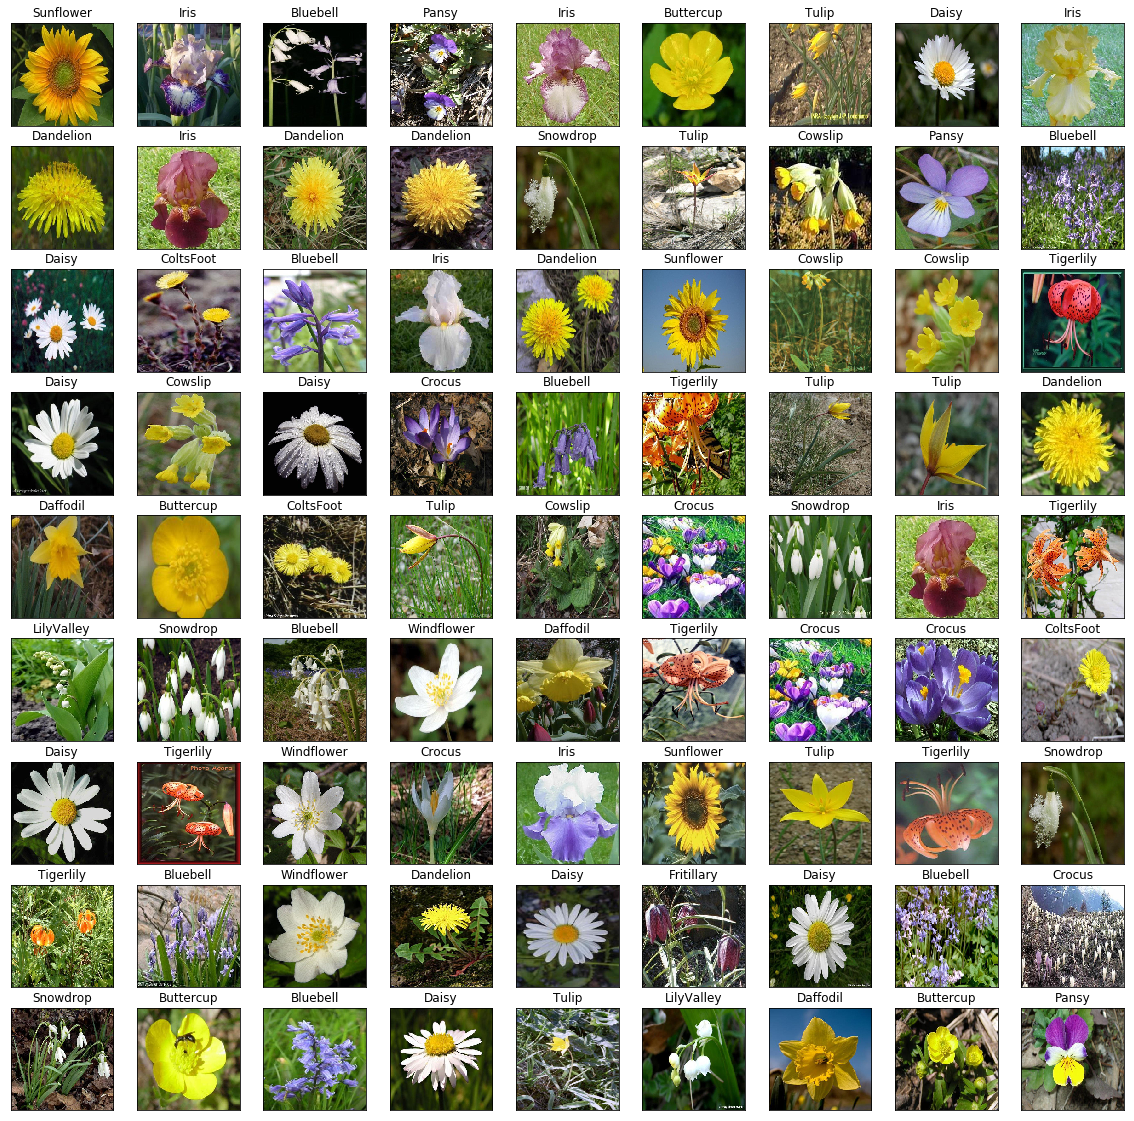

In [6]:
#plot image
fig =plt.figure(figsize=(20,20))
columns = row = 9 
for i in range(1, columns*row + 1):
    k = np.random.randint(0, len(list_image))
    fig.add_subplot(row, columns, i)
    image = load_img(image_path[k], target_size=(224, 224))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title(labelsName[k])
plt.show()

In [7]:
print(list_image.shape)
print(labels.shape)

(1360, 224, 224, 3)
(1360, 17)


In [8]:
# augmentation cho training data
aug_train = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
# augementation cho test
aug_test= ImageDataGenerator(rescale=1./255)

**3.Architect and compile**

In [9]:
def build_model():
    # Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối.
    baseModel = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

    # Xây thêm các layer
    # Lấy output của ConvNet trong VGG16
    fcHead = baseModel.output

    # Flatten trước khi dùng FCs
    fcHead = Flatten(name='flatten')(fcHead)

    # Thêm FC
    fcHead = Dense(256, activation='relu')(fcHead)
    fcHead = Dropout(0.5)(fcHead)

    # Output layer với softmax activation
    fcHead = Dense(17, activation='softmax')(fcHead)

    # Xây dựng model bằng việc nối ConvNet của VGG16 và fcHead
    model = model = Model(inputs=baseModel.input, outputs=fcHead)
    
    # unfreeze some last CNN layer:
    for layer in baseModel.layers[15:]:
        layer.trainable = True

    opt = SGD(0.001)
    model.compile(opt, 'categorical_crossentropy', ['accuracy'])
    
    return model

**4.K-fold and training**

In [10]:
k = len(list_image) // 3
num_epochs = 100
all_acc_histories = []

for i in range(3):
    print('processing fold #', i)
    X_val = list_image[i * k: (i + 1) * k]
    y_val = labels[i * k: (i + 1) * k]

    #concatenate để nối 2 array x1 với x2 thành 1 array
    X_train = np.concatenate([list_image[:i * k],
                                        list_image[(i + 1) * k:]],
                                        axis=0)

    y_train = np.concatenate([labels[:i * k],
                                            labels[(i + 1) * k:]],
                                            axis=0)
    model = build_model()
    network = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_val, y_val, batch_size=32)),
                        validation_steps=len(X_val)//32,
                        epochs=num_epochs)
    history_dict_val_acc = network.history['val_acc']
    all_acc_histories.append(history_dict_val_acc)
    #all_mae_histories.append(mae_history)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 3s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
28/28 [==============================] - 13s 468ms/step - loss: 2.9156 - acc: 0.0982 - val_loss: 2.6608 - val_acc: 0.1272
Epoch 2/100
28/28 [==============================] - 10s 373ms/step - loss: 2.6568 - acc: 0.1449 - val_loss: 2.4039 - val_acc: 0.3634
Epoch 3/100
28/28 [==============================] - 10s 352ms/step - loss: 2.3955 - acc: 0.2510 - val_loss: 2.0001 - val_acc: 0.4703
Epoch 4/100
28/28 [==============================] - 10s 355ms/step - loss: 2.0971 - acc: 0.3344 - val_loss: 1.5157 - val_acc: 0.5843
Epoch 5/100
28/28 [==============================] - 10s 362ms/step - loss: 1.7282 - acc: 0.4452 - val_loss: 1.1571 - val_acc: 0.6936
Epoch 6/10

In [11]:
model.save("model.h5")

**5. Building the history of successive mean K-fold validation scores**

In [12]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]

**6. Plotting validation scores**

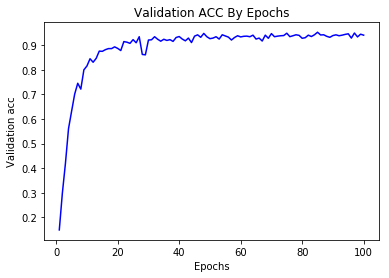

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history,'b')
plt.title('Validation ACC By Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

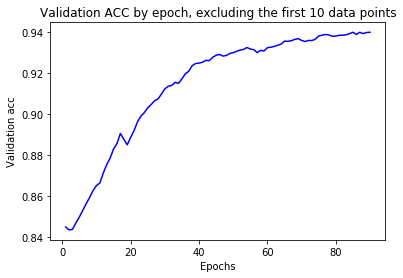

In [14]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_acc_history = smooth_curve(average_acc_history[10:])
plt.plot(range(1, len(smooth_acc_history) + 1), smooth_acc_history,'b')
plt.title('Validation ACC by epoch, excluding the first 10 data points')
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

**7. Final Training**

In [15]:
# Chia traing set, test set tỉ lệ 80-20
X_train, X_test, y_train, y_test = train_test_split(list_image, labels, test_size=0.2, random_state=42)

model = build_model()
network = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                            steps_per_epoch=len(X_train)//32,
                            validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                            validation_steps=len(X_test)//32,
                            epochs=55)

Epoch 1/55
34/34 [==============================] - 26s 777ms/step - loss: 2.9014 - acc: 0.1039 - val_loss: 2.6916 - val_acc: 0.1523
Epoch 2/55
34/34 [==============================] - 24s 694ms/step - loss: 2.6370 - acc: 0.1673 - val_loss: 2.4037 - val_acc: 0.2750
Epoch 3/55
34/34 [==============================] - 20s 591ms/step - loss: 2.3357 - acc: 0.2684 - val_loss: 1.9629 - val_acc: 0.4500
Epoch 4/55
34/34 [==============================] - 24s 706ms/step - loss: 1.9318 - acc: 0.4053 - val_loss: 1.4287 - val_acc: 0.5750
Epoch 5/55
34/34 [==============================] - 24s 698ms/step - loss: 1.6274 - acc: 0.4890 - val_loss: 1.1599 - val_acc: 0.6375
Epoch 6/55
34/34 [==============================] - 21s 612ms/step - loss: 1.3476 - acc: 0.5680 - val_loss: 0.8464 - val_acc: 0.7250
Epoch 7/55
34/34 [==============================] - 24s 718ms/step - loss: 1.0555 - acc: 0.6691 - val_loss: 0.8193 - val_acc: 0.7458
Epoch 8/55
34/34 [==============================] - 25s 743ms/step - 

In [16]:
history_dict = network.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [17]:
val_loss = history_dict['val_loss']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
acc = history_dict['acc']
epochs = range(1, len(val_loss)+1)

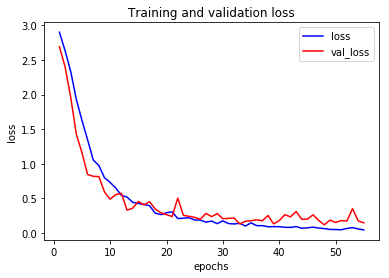

In [18]:
plt.plot(epochs, loss , 'b', label = 'loss')
plt.plot(epochs, val_loss ,'r', label = 'val_loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

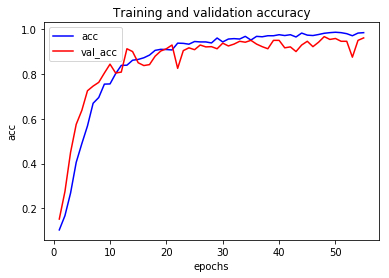

In [19]:
plt.clf()
plt.plot(epochs, acc , 'b', label = 'acc')
plt.plot(epochs, val_acc ,'r', label = 'val_acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

**8. Evaluate**

In [20]:
results = model.evaluate(X_test,y_test)
results

272/272 [==============================] - 1s 3ms/step


[3.8684723797966454, 0.7536764705882353]